## Word2Vec Approach

In [44]:
import collections
import re
import string
import unicodedata
import csv
import random

import gensim
import keras_tuner
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from bs4 import BeautifulSoup
from gensim.models import Word2Vec
from keras.activations import relu, tanh, sigmoid, linear, gelu
from keras.layers import (Bidirectional, Dense, Dropout, Embedding, GRU, LSTM,
RNN)
from keras.models import Sequential
from keras.preprocessing import sequence, text
from keras.wrappers.scikit_learn import KerasClassifier
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from lightgbm import LGBMClassifier
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier,
ExtraTreesClassifier, GradientBoostingClassifier,
RandomForestClassifier)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, roc_auc_score, roc_curve

from sklearn.model_selection import RandomizedSearchCV, cross_validate, train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from xgboost import XGBClassifier

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rusconbenito@edu.local/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Preprocessing

In [45]:
df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)
#article URLs not needed
df.drop(columns=['article_link'], inplace=True)
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
#display line with most words
print(df['headline'].str.split().apply(len).sort_values(ascending=False).head(2))
#delete headlines with more than 40 words
df = df[df['headline'].str.split().apply(len) < 40]
#remove Stopwords
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

print(df['headline'].str.split().apply(len).sort_values(ascending=False).head(2))

7302     151
24815     39
Name: headline, dtype: int64
24815    39
23598    38
Name: headline, dtype: int64


In [46]:
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [47]:
#kudos https://www.kaggle.com/code/madz2000/sarcasm-detection-with-glove-word2vec-83-accuracy#LOADING-THE-DATASET
#remove square brackets, URLs and Noise

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()
#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing numbers as it can cause additional noise
def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result

#Removing the noisy text 
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    text = remove_numbers(text)
    return text
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

/home/rusconbenito@edu.local/anaconda3/envs/NLP/lib/python3.11/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [48]:
#converting text to format acceptable by gensim

words = []
for i in df.headline.values:
    words.append(i.split())
words[:5]

[['thirtysomething',
  'scientists',
  'unveil',
  'doomsday',
  'clock',
  'hair',
  'loss'],
 ['dem',
  'rep.',
  'totally',
  'nails',
  'congress',
  'falling',
  'short',
  'gender,',
  'racial',
  'equality'],
 ['eat', 'veggies:', 'deliciously', 'different', 'recipes'],
 ['inclement', 'weather', 'prevents', 'liar', 'getting', 'work'],
 ['mother',
  'comes',
  'pretty',
  'close',
  'using',
  'word',
  "'streaming'",
  'correctly']]

## Word2Vec Model

In [49]:

#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences = words, window = 5, min_count = 1)
w2v_model.wv.vectors.shape


(37034, 100)

In [50]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
#tokenized_train = tokenizer.texts_to_sequences(words)
#x = sequence.pad_sequences(tokenized_train, maxlen = 20)
sequences = tokenizer.texts_to_sequences(words)
#help from CHTGPT
padded_sequences = pad_sequences(sequences, maxlen=20)
vocab_size = len(tokenizer.word_index) + 1

In [51]:
padded_sequences

array([[    0,     0,     0, ...,  2307,   552,   930],
       [    0,     0,     0, ..., 11228,  1972,  1787],
       [    0,     0,     0, ..., 16405,   471,  1339],
       ...,
       [    0,     0,     0, ...,   942,   662,  1633],
       [    0,     0,     0, ...,  2972,   811,  5884],
       [    0,     0,     0, ...,  2940,   171,    92]], dtype=int32)

In [52]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

In [53]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)


### Training Word2Vec model

In [54]:
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, df.is_sarcastic , test_size = 0.2 , random_state = 187) 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.25 , random_state = 187)

In [55]:


# Define the model architecture
# Refactoring of Dennis Code with CHATGPT
def build_model(hp):
    model = keras.Sequential()

    model.add(layers.Embedding(vocab_size, output_dim=100, weights=[embedding_vectors], trainable=True))

    for i in range(hp.Int("num_layers", 1, 4)):
        for layer_type in [LSTM, GRU]:
            model.add(Bidirectional(layer_type(units=hp.Int(f"units_{i}", min_value=8, max_value=96, step=2),
                                               recurrent_dropout=hp.Float(f"recurrent_dropout_{i}", min_value=0.0, max_value=0.5, step=0.1),
                                               dropout=hp.Float(f"dropout_{i}", min_value=0.0, max_value=0.5, step=0.1),
                                               activation=hp.Choice(f"activation_{i}", values=["relu", "tanh", "sigmoid", "linear", "gelu"]),
                                               return_sequences=True),
                                               name=f"bidirectional_{layer_type.__name__.lower()}_{i}"))

    learning_rate_tuned = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    model.add(layers.Dense(1, activation="sigmoid", name="output"))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate_tuned),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    return model

# Wrap the model in a scikit-learn classifier for use with randomized search
model = KerasClassifier(build_fn=build_model, batch_size=512, verbose=0)

# Define the hyperparameter space for randomized search
param_distributions = {
    "num_layers": [1, 2, 3],
    "units_0": list(range(4, 65, 2)),
    "recurrent_dropout_0": np.arange(0.0, 0.6, 0.1),
    "dropout_0": np.arange(0.0, 0.8, 0.1),
    "activation_0": ["relu", "tanh", "sigmoid", "linear", "gelu"],
    "units_1": list(range(4, 65, 2)),
    "recurrent_dropout_1": np.arange(0.0, 0.3, 0.1),
    "dropout_1": np.arange(0.0, 0.8, 0.1),
    "activation_1": ["relu", "tanh", "sigmoid", "linear", "gelu"],
    "units_2": list(range(4, 65, 2)),
    "recurrent_dropout_2": np.arange(0.0, 0.3, 0.1),
    "dropout_2": np.arange(0.0, 0.8, 0.1),
    "activation_2": ["relu", "tanh", "linear", "gelu"],
    "lr": np.logspace(-4, -2, num=10)
}


batch_sizes = [32, 64, 128, 256]

/tmp/ipykernel_695298/3787057503.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=build_model, batch_size=512, verbose=0)


In [56]:



class TerminationOnNoImprovement(keras.callbacks.Callback):
    def __init__(self, patience=5, restore_best_weights=True):
        super(TerminationOnNoImprovement, self).__init__()
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best_weights = None
        self.best_epoch = None
        self.best_val_acc = None

    def on_train_begin(self, logs=None):
        self.best_weights = self.model.get_weights()
        self.best_epoch = 0
        self.best_val_acc = -float('inf')

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc > self.best_val_acc:
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch
            self.best_val_acc = val_acc
        elif epoch - self.best_epoch >= self.patience:
            print(f'Epoch {epoch}: early stopping')
            self.model.stop_training = True
            if self.restore_best_weights:
                print(f'Restored model weights from epoch {self.best_epoch}')
                self.model.set_weights(self.best_weights)




In [57]:
tuner = RandomSearch(
    build_model, objective='val_accuracy',
    max_trials=100, executions_per_trial=1,
    directory='my_dir',project_name='NLP_Tuner'
)

batch_sizes = [16,32, 64, 128, 256,512,1024,2048]


best_batch_size = None; best_model = None; best_hparams = None; best_val_acc = -float('inf')

for batch_size in batch_sizes:
    batch_size = random.choice(batch_sizes)
    print(f'Batch size: {batch_size}')
    tuner.search(x_train, y_train, epochs=50, validation_split=0.2, batch_size=batch_size, callbacks=[TerminationOnNoImprovement()])
    trial_best_model = tuner.get_best_models(num_models=1)[0]
    trial_best_hparams = tuner.get_best_hyperparameters(num_trials=1)[0]
    trial_best_val_acc = tuner.get_best_trial('val_accuracy').score

    if trial_best_val_acc > best_val_acc:
        best_batch_size = batch_size
        best_model = trial_best_model
        best_hparams = trial_best_hparams
        best_val_acc = trial_best_val_acc

print(f'Best batch size: {best_batch_size}')
print(f'Best validation accuracy: {best_val_acc}')
print(f'Best hyperparameters: {best_hparams.values}')

Batch size: 512

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
1                 |1                 |num_layers
14                |14                |units_0
0                 |0                 |recurrent_dropout_0
0.2               |0.2               |dropout_0
linear            |linear            |activation_0
0.0039504         |0.0039504         |lr

Epoch 1/50
27/27 [==============================] - 8s 97ms/step - loss: 0.6371 - accuracy: 0.6244 - val_loss: 1.0631 - val_accuracy: 0.5226
Epoch 2/50
27/27 [==============================] - 2s 62ms/step - loss: 0.2794 - accuracy: 0.8872 - val_loss: 0.7004 - val_accuracy: 0.5449
Epoch 3/50
14/27 [==============>...............] - ETA: 0s - loss: 0.0927 - accuracy: 0.9683

KeyboardInterrupt: 

In [ ]:
# Start the hyperparameter search
tuner.search(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[threshold_callback])

# Print the summary of the search
tuner.results_summary()

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps}")


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
1                 |1                 |num_layers
46                |46                |units_0
0.4               |0.4               |recurrent_dropout_0
0.3               |0.3               |dropout_0
sigmoid           |sigmoid           |activation_0
0.001294          |0.001294          |lr



Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7fdc6e334a40>
Traceback (most recent call last):
  File "/home/rusconbenito@edu.local/anaconda3/envs/NLP/lib/python3.11/weakref.py", line 369, in remove
    def remove(k, selfref=ref(self)):

KeyboardInterrupt: 


Epoch 1/50
527/535 [============================>.] - ETA: 0s - loss: 0.6010 - accuracy: 0.6434

In [ ]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense, Flatten
from tensorflow.keras.models import Sequential

# Defining Neural Network
model = Sequential()

# Non-trainable embedding layer
model.add(Embedding(vocab_size, output_dim=100, weights=[embedding_vectors], trainable=True))

# LSTM 
model.add(Bidirectional(LSTM(units=256, activation='gelu', recurrent_dropout=0.1, dropout=0.8, return_sequences=True)))
model.add(Bidirectional(GRU(units=192, activation='gelu', recurrent_dropout=0.1, dropout=0.8, return_sequences=True)))
model.add(Bidirectional(LSTM(units=128, activation='gelu', recurrent_dropout=0.1, dropout=0.8, return_sequences=True)))
model.add(Bidirectional(GRU(units=96, activation='gelu', recurrent_dropout=0.1, dropout=0.8, return_sequences=True)))
# Output layer
model.add(Dense(1, activation='tanh'))
#model.add(Flatten())  # Convert 2D tensor to 1D tensor
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['acc'])



In [ ]:

#early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose=1, mode='auto')
history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_val,y_val) , epochs = 1000, callbacks=[early_stopping])



Epoch 1/1000
134/134 [==============================] - 61s 292ms/step - loss: 1.6376 - acc: 0.5244 - val_loss: 0.9752 - val_acc: 0.5395
Epoch 2/1000
134/134 [==============================] - 37s 275ms/step - loss: 0.8396 - acc: 0.5497 - val_loss: 0.7363 - val_acc: 0.5592
Epoch 3/1000
134/134 [==============================] - 37s 275ms/step - loss: 0.7267 - acc: 0.5540 - val_loss: 0.7025 - val_acc: 0.5579
Epoch 4/1000
134/134 [==============================] - 37s 276ms/step - loss: 0.6997 - acc: 0.5555 - val_loss: 0.6912 - val_acc: 0.5602
Epoch 5/1000
134/134 [==============================] - 37s 277ms/step - loss: 0.6904 - acc: 0.5580 - val_loss: 0.6851 - val_acc: 0.5633
Epoch 6/1000
134/134 [==============================] - 37s 275ms/step - loss: 0.6829 - acc: 0.5654 - val_loss: 0.6812 - val_acc: 0.5640
Epoch 7/1000
134/134 [==============================] - 37s 275ms/step - loss: 0.6697 - acc: 0.5876 - val_loss: 0.6660 - val_acc: 0.5896
Epoch 8/1000
134/134 [===================

KeyboardInterrupt: 

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_val,y_val)[1]*100)

537/537 [==============================] - 8s 15ms/step - loss: 0.0479 - acc: 0.9865
Accuracy of the model on Training Data is -  98.64888191223145
179/179 [==============================] - 3s 16ms/step - loss: 0.5577 - acc: 0.8021
Accuracy of the model on Testing Data is -  80.20614981651306


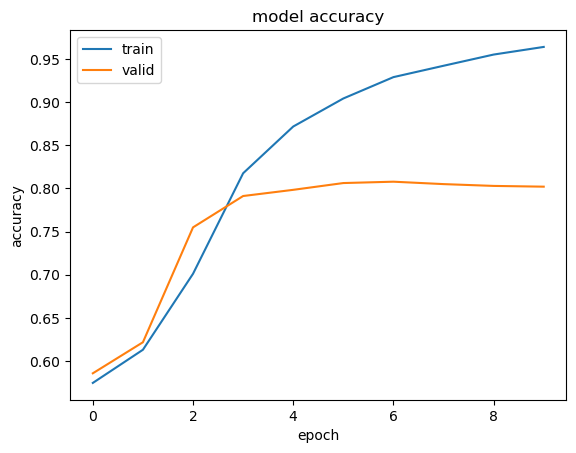

In [ ]:
#plot accuracy and loss
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


## Maschine Learning

In [ ]:
#CHTGPT

# Define the models to be compared
models = [
    ('Multinomial Naive Bayes', MultinomialNB()),
    ('Logistic Regression', LogisticRegression(random_state=187, max_iter=10000)),
    ('Decision Tree', DecisionTreeClassifier(random_state=187)),
    ('Random Forest', RandomForestClassifier(random_state=187)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=187)),
    ('XGBoost', XGBClassifier(random_state=187)),
    ('LightGBM', LGBMClassifier(random_state=187)),
    ('MLP', MLPClassifier(random_state=187)),
    ('SVM', SVC(random_state=187)),
    ('KNN', KNeighborsClassifier()),
    ('AdaBoost', AdaBoostClassifier(random_state=187)),
    ('Bagging', BaggingClassifier(random_state=187)),
    ('ExtraTrees', ExtraTreesClassifier(random_state=187)),
    ('NuSVC', NuSVC(random_state=187)),  
    ('PassiveAggressive', PassiveAggressiveClassifier(random_state=187)),
    ('MultinomialNB', MultinomialNB())    
                  
]


# Create an empty dataframe to store the results
results_df = pd.DataFrame(columns=['Model', 'Train Score', 'Validation Score', 'Test Score'])

# Evaluate the models using 5-fold cross-validation
kfold = KFold(n_splits=5, random_state=187, shuffle=True)
for name, model in models:
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)
    train_score = cv_results.mean()
    validation_score = model.fit(x_train, y_train).score(x_val, y_val)
    test_score = model.fit(x_train, y_train).score(x_test, y_test)
    results_df = pd.concat([results_df, pd.DataFrame([[name, train_score, validation_score, test_score]], 
                                                      columns=['Model', 'Train Score', 'Validation Score', 'Test Score'])], 
                            ignore_index=True)
    print(f"{name}: Train Score: {train_score:.2f}, Validation Score: {validation_score:.2f}, Test Score: {test_score:.2f}")

# Print the results dataframe
print(results_df)


Multinomial Naive Bayes: Train Score: 0.56, Validation Score: 0.56, Test Score: 0.56
Logistic Regression: Train Score: 0.56, Validation Score: 0.55, Test Score: 0.56
Decision Tree: Train Score: 0.56, Validation Score: 0.56, Test Score: 0.56
Random Forest: Train Score: 0.61, Validation Score: 0.61, Test Score: 0.62
Gradient Boosting: Train Score: 0.61, Validation Score: 0.61, Test Score: 0.61
XGBoost: Train Score: 0.63, Validation Score: 0.64, Test Score: 0.64
LightGBM: Train Score: 0.63, Validation Score: 0.63, Test Score: 0.63
MLP: Train Score: 0.53, Validation Score: 0.53, Test Score: 0.54
SVM: Train Score: 0.57, Validation Score: 0.57, Test Score: 0.56
KNN: Train Score: 0.53, Validation Score: 0.54, Test Score: 0.53
AdaBoost: Train Score: 0.59, Validation Score: 0.59, Test Score: 0.59
Bagging: Train Score: 0.58, Validation Score: 0.58, Test Score: 0.59
ExtraTrees: Train Score: 0.58, Validation Score: 0.58, Test Score: 0.58
NuSVC: Train Score: 0.54, Validation Score: 0.55, Test Score

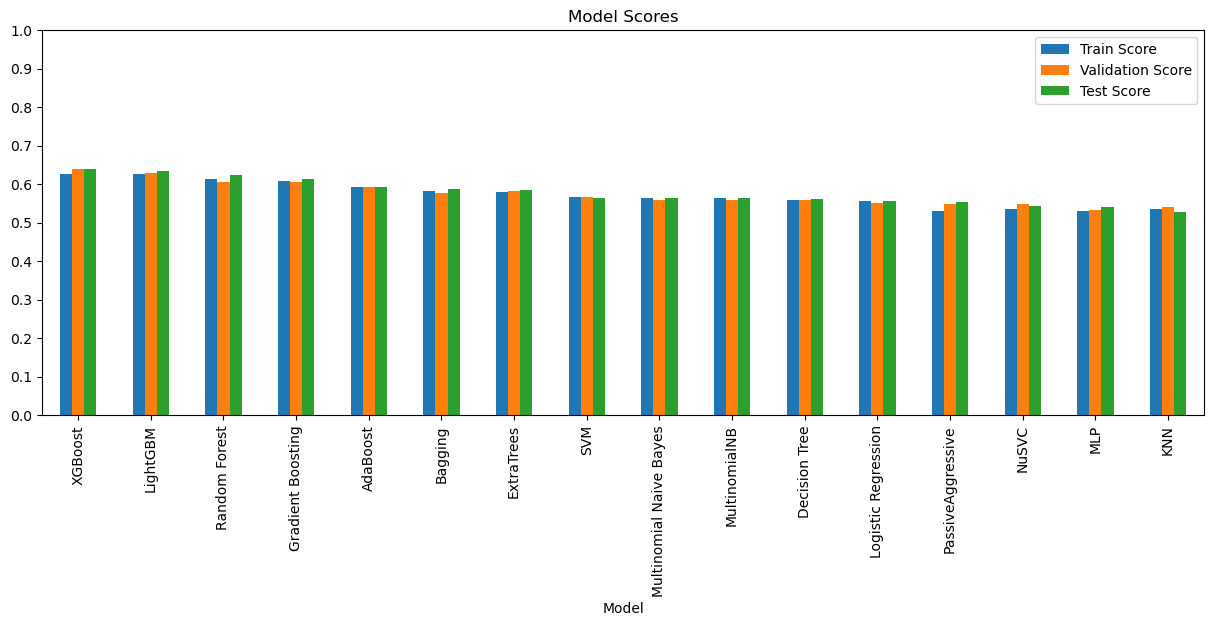

In [ ]:
#bar chart of results_df sort by test score
results_df.sort_values(by='Test Score', ascending=False).plot(x='Model', y=['Train Score', 'Validation Score', 'Test Score'], kind='bar', figsize=(15, 5), title='Model Scores')
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.show()


